# Setup
We set a seed for reproducibility, and import necessary packages.

In [110]:
SEED = 10

In [111]:
import networkx as nx                 # Network uttilities
import matplotlib.pyplot as plt       # Plotting
import numpy as np                    # Always useful
from scipy.cluster import hierarchy   # Plotting dendrograms, linkage methods, etc.
from scipy.spatial import distance    # Computing all-pairs shortest paths
from sklearn import metrics           # Silhouette score dependency
import pandas as pd                   # For using dataframes
import statistics

# As a formality, since it is not necessary anymore
%matplotlib inline  

## Ensemble Class
Below a class is defined that creates an ensemble of hierarchical clustering algorithms. We have a group of agglomerative clustering methods, that differ in their linkage method. We use the average silhouette method to determine the cutoff point for each dendrogram. Then we cluster these clusters into hyperclusters, using pairwise occurence.

Note: we extend the definition of a "dendrogram" to not only being a diagram, but also the linkage matrix.

In [112]:
class Ensemble:
    def __init__(self, label: str, data, algorithms: dict[list], max_clusters: int):
        self.label = label
        self.data = data
        self.n_nodes = len(self.data)
        self.algorithms = algorithms
        self.max_clusters = max_clusters
        self.consensus_method = consensus_method
        self.distances = self.create_distance_matrix()
        self.dendrograms = {}
        self.clusterings = {}
        self.silhouette_scores = pd.DataFrame(columns=["algorithm", "n_clusters", "score"])
        self.co_occurrences = None
        self.dendrogram = None

    
    """
    Run all algorithms in the ensemble, and create a single dendrogram.
    """
    def run(self, consensus_method: str):
        # Find clusterings
        for method in self.algorithms.keys():
            for linkage in self.algorithms[method]:
                if method == "agglomerative":
                    clustering, dendrogram = self.agglomerative(linkage)
                elif method == "divisive":
                    clustering, dendrogram = self.divisive(linkage)
                else:
                    raise ValueError
                self.clusterings[f"{method}-{linkage}"] = clustering
                self.dendrograms[f"{method}-{linkage}"] = dendrogram
                
        # Create hyperclusters
        self.create_co_occurrence_matrix()
        self.find_consensus(consensus_method)
        
    
    """
    Create a distance matrix using all pairs shortest path between vertices.
    """
    def create_distance_matrix(self):
        path_length = nx.all_pairs_shortest_path_length(self.data)
        distances = np.zeros((self.n_nodes, self.n_nodes))
        for node, info in path_length:
            for other_node, l in info.items():
                distances[node][other_node] = l
                distances[other_node][node] = l
                if node == other_node:
                    distances[node][node] = 0
        return distances
        
    
    """
    Agglomerative clustering (Ravasz).
    """
    def agglomerative(self, linkage: str):
        condensed_distances = distance.squareform(self.distances)
        dendrogram = hierarchy.linkage(condensed_distances, method=linkage)
        best_cut = self.find_best_cut(dendrogram, algorithm="agglomerative", linkage=linkage)
        clustering = hierarchy.fcluster(dendrogram, t=best_cut, criterion="maxclust")
        return clustering, dendrogram
    
    
    """
    Divisive clustering (Girvan-Newman).
    """
    def divisive(self, linkage: str):
        # Create the linkage function
        def linkage_function(G):
            if linkage == "betweenness":
                centrality = nx.edge_betweenness_centrality(G)
            elif linkage == "load":
                centrality = nx.edge_load_centrality(G)
            return max(centrality, key=centrality.get)
        
        # Cast iterator type to list for convenience
        dendrogram = list(nx.community.girvan_newman(self.data, most_valuable_edge=linkage_function))
        best_cut = self.find_best_cut(dendrogram, algorithm="divisive", linkage=linkage)
        clustering = self.convert_girvan_newman_clustering(dendrogram[best_cut - 1])
        return clustering, dendrogram
    
    
    """
    Helper function to convert a list of clusters to a single list of assignments.
    """
    def convert_girvan_newman_clustering(self, clustering):
        cluster_assignments = [None] * len(self.data)
        i = 1
        for cluster in list(clustering):
            for node in cluster:
                cluster_assignments[node] = i
            i += 1
        return cluster_assignments
    
    
    """
    Find optimal number of clusters for agglomerative procedurs, using silhouette score.
    """
    def find_best_cut(self, clusterings, algorithm, linkage):
        best_cut = 1
        best_score = -1
        for i in range(2, self.max_clusters):
            try:
                # Cut the number of clusters
                if algorithm == "agglomerative":
                    nodes = hierarchy.fcluster(clusterings, t=i, criterion="maxclust")
                elif algorithm == "divisive":
                    nodes = self.convert_girvan_newman_clustering(clusterings[i - 1])
                else:
                    raise ValueError
                
                score = metrics.silhouette_score(self.distances, nodes, metric="euclidean")
                if score > best_score:
                    best_cut = i
                    best_score = score
                    
                # Store silhouette scores for output analysis
                self.silhouette_scores.loc[len(self.silhouette_scores.index)] = [f"{algorithm}-{linkage}", i, score] 
            except Exception as e:
                print(e)
        
        return best_cut
    
    
    """
    Go through all clusterings and store the pairwise co occurence.
    """
    def create_co_occurrence_matrix(self):
        max_co_occurrences = len(algorithms["agglomerative"]) + len(algorithms["divisive"])
        self.co_occurrences = np.full((self.n_nodes, self.n_nodes), max_co_occurrences)
        for clustering in self.clusterings.values():
            for i in range(self.n_nodes):
                for j in range(i, self.n_nodes):
                    if clustering[i] == clustering[j]:
                        self.co_occurrences[i][j] -= 1
                        self.co_occurrences[j][i] -= 1
                        if i == j:
                            self.co_occurrences[i][j] = 0
                            
    
    """
    Final method in the ensemble approach to create a single dendrogram.
    """
    def find_consensus(self, consensus_method):
        condensed_distances = distance.squareform(self.co_occurrences)
        dendrogram = hierarchy.linkage(condensed_distances, method=consensus_method)
        self.dendrogram = dendrogram
        
    
    """
    Converts dendrogram to a dataframe containing the clusters.
    """
    def to_clusters(self, max_clusters: int):
        clustering = hierarchy.fcluster(self.dendrogram, t=max_clusters, criterion="maxclust")
        df_clusters = pd.DataFrame(columns=["node", "cluster"])
        for i in range(len(clustering)):
            df_clusters.loc[i] = [i + 1, clustering[i]]
        return df_clusters

# Karate Club
We use the Karate Club network as an initial experiment, for which we know the ground truth. This dataset has $34$ nodes and $78$ edges, and two ground truth clusters; Mr. Hi (`mrhi`), and John A. (`johna`).

In [113]:
G = nx.karate_club_graph()

# Add ground truth
mrhi = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
johna = [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
for node in G.nodes():
    if node in mrhi:
        G.nodes()[node]["group"] = "mrhi"
    else:
        G.nodes()[node]["group"] = "johna"

We will plot the network below. The red nodes belong to Mr. Hi and the blue nodes to John A.

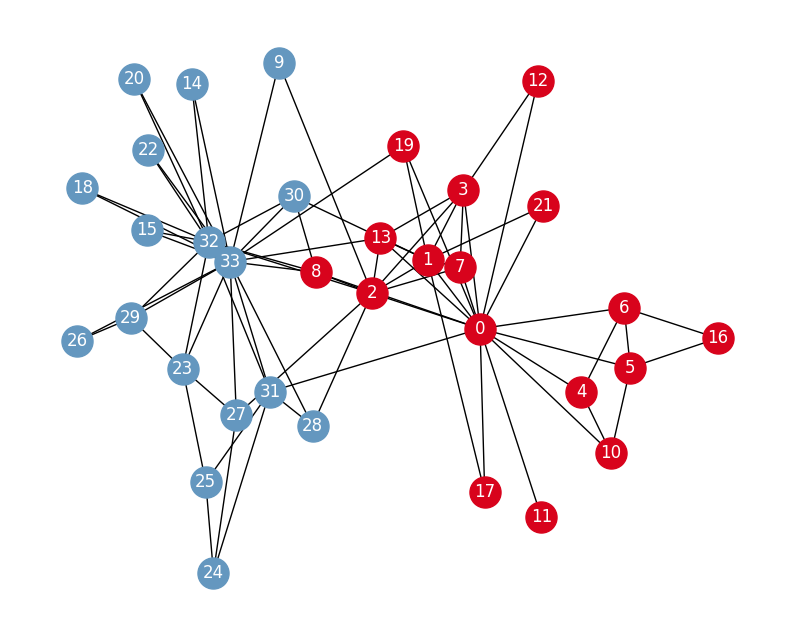

In [114]:
# Fix a structure for the vertices
coors = nx.spring_layout(G, seed=SEED)

plt.figure(figsize=(10, 8))
plt.axis("off")
nx.draw_networkx_nodes(G, coors, nodelist=mrhi, node_size=500, node_color="#d8031c")
nx.draw_networkx_nodes(G, coors, nodelist=johna, node_size=500, node_color="#6497bf")
nx.draw_networkx_edges(G, coors)
nx.draw_networkx_labels(G, coors, font_color="white")
plt.savefig("figures/karate/network_karate.png", bbox_inches="tight")
plt.show()

### First Ensemble
We create our first ensemble for the Karate Club network. Below we setup the algorithms used in the ensemble.

In [115]:
max_clusters = 10
consensus_method = "average"
algorithms = {
    "agglomerative": ["complete", "average", "weighted", "centroid", "median", "ward"],
    "divisive": ["betweenness", "load"]
}

ensemble = Ensemble(label="ensemble", data=G, algorithms=algorithms, max_clusters=max_clusters)
ensemble.run(consensus_method=consensus_method)

In [116]:
ensemble.silhouette_scores.to_csv("data/results/silhouette_scores_karate.csv", index=False)

In [117]:
df_nmi = pd.DataFrame(columns=["algorithm", "nmi"])

# Put the ground truth in the same data structure as the clusterings
ground_truth = [None] * 34
for i in range(len(mrhi)):
    ground_truth[mrhi[i]] = 1
for i in range(len(johna)):
    ground_truth[johna[i]] = 2

# Print normalized mutual information score for ensemble and each inner algorithm
clustering = hierarchy.fcluster(ensemble.dendrogram, t=2, criterion="maxclust")
nmi = metrics.normalized_mutual_info_score(ground_truth, clustering)
df_nmi.loc[len(df_nmi.index)] = ["ensemble", nmi]

for algorithm, clustering in ensemble.clusterings.items():
    nmi = metrics.normalized_mutual_info_score(ground_truth, clustering)
    df_nmi.loc[len(df_nmi.index)] = [algorithm, nmi]
    
df_nmi.to_csv("data/results/nmi_karate.csv", index=False)

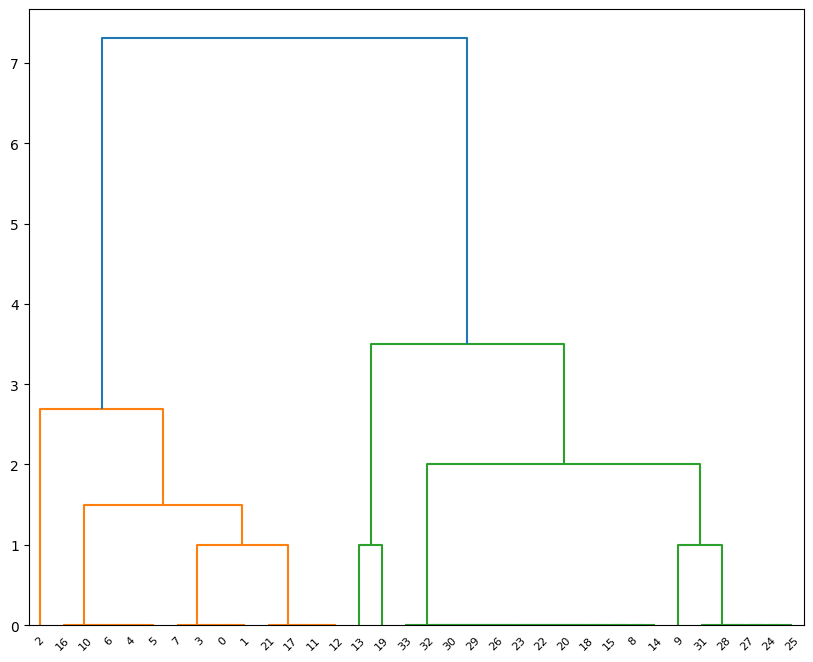

In [121]:
plt.figure(figsize=(10, 8))
hierarchy.dendrogram(ensemble.dendrogram)
plt.savefig("figures/karate/ensemble_dendrogram_karate.png", bbox_inches="tight")
plt.show()

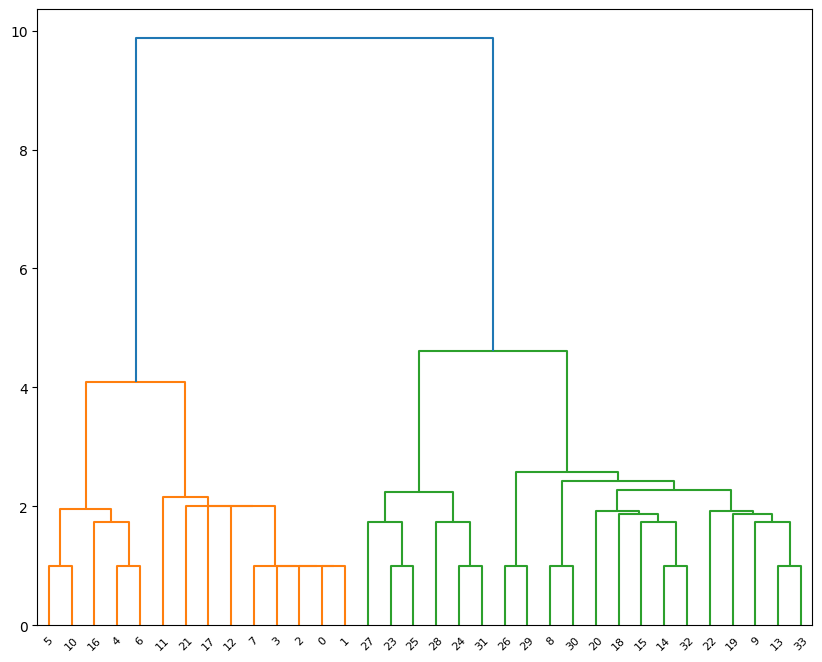

In [120]:
plt.figure(figsize=(10, 8))
hierarchy.dendrogram(ensemble.dendrograms["agglomerative-ward"])
plt.savefig("figures/karate/agglomerative_complete_dendrogram_karate.png", bbox_inches="tight")
plt.show()

# American College Football

In [122]:
G = nx.read_gml("data/networks/football/football.gml")
mapping = {}
nodes = list(G.nodes)
for i in range(len(nodes)):
    mapping[nodes[i]] = i
G = nx.relabel_nodes(G, mapping)

In [123]:
print(G)

Graph with 115 nodes and 613 edges


In [124]:
from collections import defaultdict
node_lists = defaultdict(list)

for i in range(len(G.nodes)):
    group = G.nodes[i]["value"]
    node_lists[group].append(i)

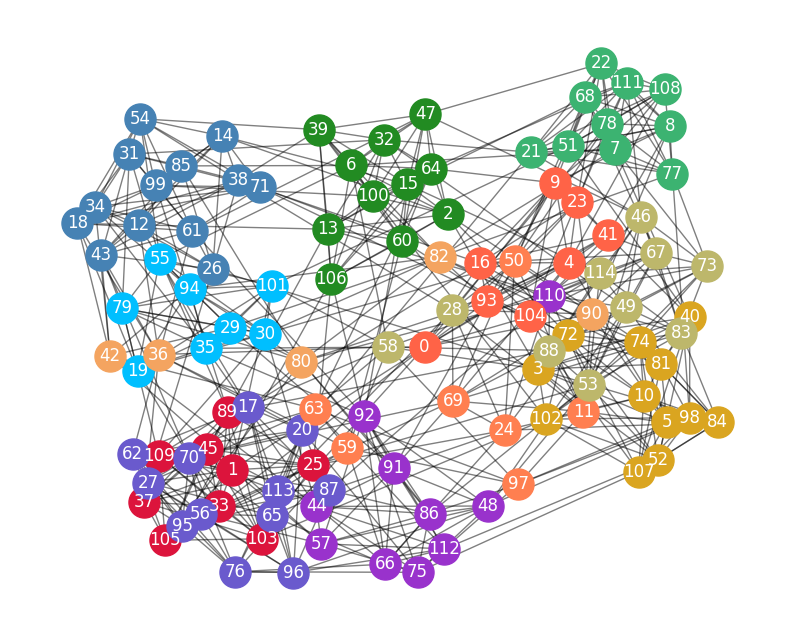

In [125]:
color_palette = [
    "#DC143C",
    "#00BFFF",
    "#228B22",
    "#DAA520",
    "#9932CC",
    "#F4A460",
    "#4682B4",
    "#FF6347",
    "#3CB371",
    "#6A5ACD",
    "#FF7F50",
    "#BDB76B"
]

coors = nx.spring_layout(G, seed=SEED)
plt.figure(figsize=(10, 8))
plt.axis("off")
for i in range(len(node_lists)):
    nx.draw_networkx_nodes(G, coors, nodelist=node_lists[i], node_size=500, node_color=color_palette[i])
nx.draw_networkx_edges(G, coors, alpha=0.5)
nx.draw_networkx_labels(G, coors, font_color="white")
plt.savefig("figures/football/network_football.png", bbox_inches="tight")
plt.show()

In [126]:
max_clusters = 20
consensus_method = "average"
algorithms = {
    "agglomerative": ["complete", "average", "weighted", "centroid", "median", "ward"],
    "divisive": ["betweenness", "load"]
}

ensemble = Ensemble(label="ensemble", data=G, algorithms=algorithms, max_clusters=20)
ensemble.run(consensus_method=consensus_method)

Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


In [127]:
ensemble.silhouette_scores.to_csv("data/results/silhouette_scores_football.csv", index=False)

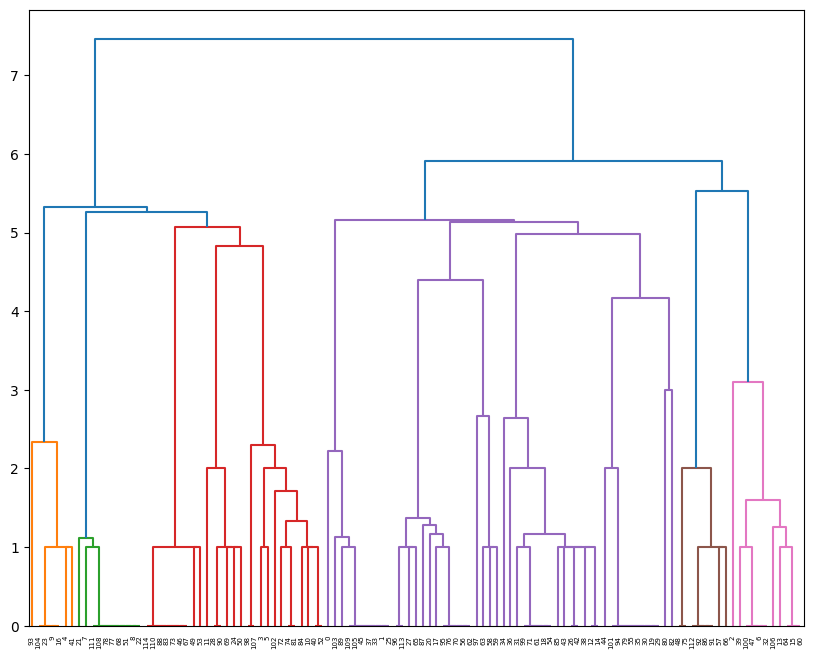

In [128]:
plt.figure(figsize=(10, 8))
hierarchy.dendrogram(ensemble.dendrogram)
plt.savefig("figures/football/ensemble_dendrogram_football.png", bbox_inches="tight")
plt.show()

In [129]:
ground_truth = []
for i in range(len(G)):
    ground_truth.append(G.nodes[i]["value"])
print(ground_truth)

[7, 0, 2, 3, 7, 3, 2, 8, 8, 7, 3, 10, 6, 2, 6, 2, 7, 9, 6, 1, 9, 8, 8, 7, 10, 0, 6, 9, 11, 1, 1, 6, 2, 0, 6, 1, 5, 0, 6, 2, 3, 7, 5, 6, 4, 0, 11, 2, 4, 11, 10, 8, 3, 11, 6, 1, 9, 4, 11, 10, 2, 6, 9, 10, 2, 9, 4, 11, 8, 10, 9, 6, 3, 11, 3, 4, 9, 8, 8, 1, 5, 3, 5, 11, 3, 6, 4, 9, 11, 0, 5, 4, 4, 7, 1, 9, 9, 10, 3, 6, 2, 1, 3, 0, 7, 0, 2, 3, 8, 0, 4, 8, 4, 9, 11]


In [131]:
def fcluster_girvan_newman(n_nodes, clusterings, t: int):
    cluster_assignments = [None] * n_nodes
    i = 1
    for cluster in list(clusterings[t-1]):
        for node in cluster:
            cluster_assignments[node] = i
        i += 1
    return cluster_assignments

In [132]:
n_nodes = len(G)

df_nmi = pd.DataFrame(columns=["algorithm", "nmi"])

# Put the ground truth in the same data structure as the clusterings
ground_truth = []
for i in range(len(G)):
    ground_truth.append(G.nodes[i]["value"])

# Print normalized mutual information score for ensemble and each inner algorithm
clustering = hierarchy.fcluster(ensemble.dendrogram, t=12, criterion="maxclust")
nmi = metrics.normalized_mutual_info_score(ground_truth, clustering)
df_nmi.loc[len(df_nmi.index)] = ["ensemble", nmi]

for algorithm, _ in ensemble.clusterings.items():
    if algorithm.startswith("agglomerative"):
        clustering = hierarchy.fcluster(
            ensemble.dendrograms[algorithm], 
            t=12, 
            criterion="maxclust"
        )
    elif algorithm.startswith("divisive"):
        clustering = fcluster_girvan_newman(
            n_nodes, 
            ensemble.dendrograms[algorithm],
            t=12
        )
    nmi = metrics.normalized_mutual_info_score(ground_truth, clustering)
    df_nmi.loc[len(df_nmi.index)] = [algorithm, nmi]
    
df_nmi.to_csv("data/results/nmi_football.csv", index=False)

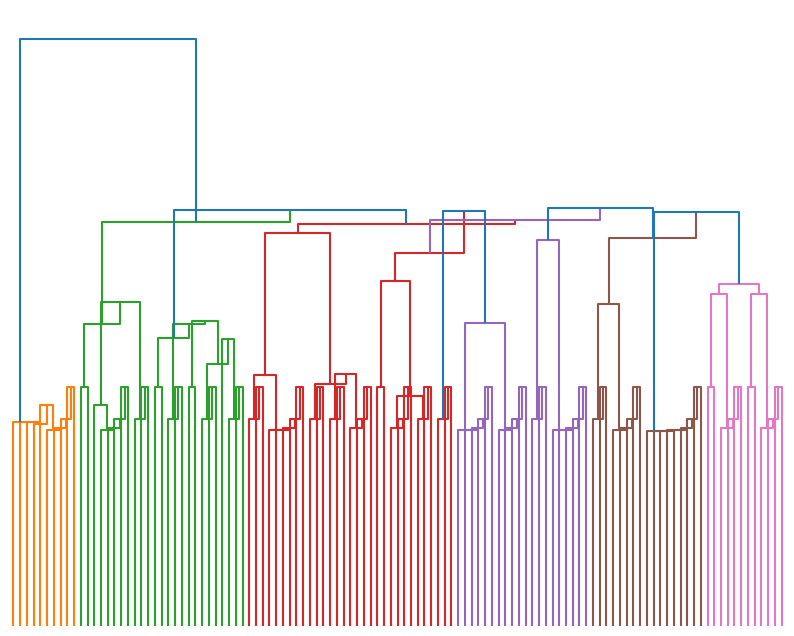

In [133]:
plt.figure(figsize=(10, 8))
hierarchy.dendrogram(ensemble.dendrograms["agglomerative-median"], no_labels=True)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig("figures/misc/example_dendrogram.png", bbox_inches="tight")
plt.show()

# Creating a benchmark: RB-LFR
Below we some tests can be found to create the RB-LFR benchmark (not used in paper, but can be used for further research). The idea is to use the LFR benchmark, and extend it using the RB paradigm. We generate a single LFR, replicate this $R$ times, connect each community hub to its direct neighbors in a lower community hub.

In [280]:
# Generate LFR
from networkx.generators.community import LFR_benchmark_graph

n = 250
tau1 = 3
tau2 = 1.5
mu = 0.1
max_degree = int(0.1 * n)
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=5, min_community=20, seed=SEED, max_degree=max_degree
)

In [281]:
# Find community hubs
communities = {frozenset(G.nodes[v]["community"]) for v in G}
degrees = G.degree()

hubs = {}
for n, community in zip(range(len(communities)), list(communities)):
    curr_hub = None
    curr_degree = 0
    for node in list(community):
        degree = degrees[node]
        if degree > curr_degree:
            curr_hub = node
            curr_degree = degree
    hubs[n] = curr_hub

In [282]:
from copy import deepcopy
_G = deepcopy(G)

G1 = deepcopy(G)
for v in G1:
    G1.nodes[v]["community"] = {value + 250 * 1 for value in G1.nodes[v]["community"]} 

G2 = deepcopy(G)
for v in G2:
    G2.nodes[v]["community"] = {value + 250 * 2 for value in G2.nodes[v]["community"]}
G3 = deepcopy(G)
for v in G3:
    G3.nodes[v]["community"] = {value + 250 * 3 for value in G3.nodes[v]["community"]}

G4 = deepcopy(G)
for v in G4:
    G4.nodes[v]["community"] = {value + 250 * 4 for value in G4.nodes[v]["community"]}


# Adding G1
mapping = {}
for j in range(250):
    mapping[j] = j + 250 * 1
G1 = nx.relabel_nodes(G1, mapping)
G = nx.compose(G, G1)
for hub in hubs:
    for neighbor in _G.neighbors(hub):
        G.add_edge(hub, neighbor + 250 * 1)
        
        
# Adding G2
mapping = {}
for j in range(250):
    mapping[j] = j + 250 * 2
G2 = nx.relabel_nodes(G2, mapping)
G = nx.compose(G, G2)
for hub in hubs:
    for neighbor in _G.neighbors(hub):
        G.add_edge(hub, neighbor + 250 * 2)


# Adding G3
mapping = {}
for j in range(250):
    mapping[j] = j + 250 * 3
G3 = nx.relabel_nodes(G3, mapping)
G = nx.compose(G, G3)
for hub in hubs:
    for neighbor in _G.neighbors(hub):
        G.add_edge(hub, neighbor + 250 * 3)


# Adding G4
mapping = {}
for j in range(250):
    mapping[j] = j + 250 * 4
G4 = nx.relabel_nodes(G4, mapping)
G = nx.compose(G, G4)
for hub in hubs:
    for neighbor in _G.neighbors(hub):
        G.add_edge(hub, neighbor + 250 * 4)

In [283]:
print(G)

Graph with 1250 nodes and 2892 edges


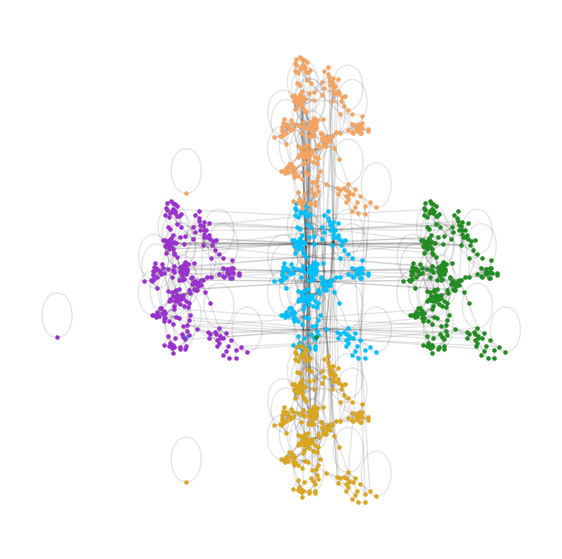

In [286]:
coors = nx.spring_layout(_G, seed=SEED)
_coors = deepcopy(coors)
for key in _coors:
    coors[key + 250 * 1] = deepcopy(coors[key])
    coors[key + 250 * 1][0] += 1
    
    coors[key + 250 * 2] = deepcopy(coors[key])
    coors[key + 250 * 2][1] -= 1
    
    coors[key + 250 * 3] = deepcopy(coors[key])
    coors[key + 250 * 3][0] -= 1
    
    coors[key + 250 * 4] = deepcopy(coors[key])
    coors[key + 250 * 4][1] += 1


plt.figure(figsize=(7, 7))
plt.axis("off")
nx.draw_networkx_nodes(G, coors, nodelist=list(range(0, 250)), node_size=5, node_color="#00BFFF")
nx.draw_networkx_nodes(G, coors, nodelist=list(range(250, 500)), node_size=5, node_color="#228B22")
nx.draw_networkx_nodes(G, coors, nodelist=list(range(500, 750)), node_size=5, node_color="#DAA520")
nx.draw_networkx_nodes(G, coors, nodelist=list(range(750, 1000)), node_size=5, node_color="#9932CC")
nx.draw_networkx_nodes(G, coors, nodelist=list(range(1000, 1250)), node_size=5, node_color="#F4A460")
nx.draw_networkx_edges(G, coors, alpha=0.1)
plt.show()

In [289]:
algorithms = {
    "agglomerative": ["complete", "average", "weighted", "centroid", "median", "ward"]
}
ensemble = Ensemble(label="ensemble", data=G, algorithms=algorithms, max_clusters=max_clusters)
ensemble.run(consensus_method=consensus_method)

Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
